In [2]:
#第一步数据预处理
#数据预处理
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# 数据读取
data = pd.read_csv(r"/kaggle/input/yuangonglizhi-data/.csv")  

# 检查数据的基本信息
data.info()
print(data.head())

# **1. 删除无关变量（如果存在）**
# 当前数据中没有需要删除的列，所以此步可以跳过

# **2. 处理无序类别变量**
# 工资（无序类别变量）
cols_categories = ['工资']
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' 避免多重共线性
encoded_data = encoder.fit_transform(data[cols_categories])
encoded_columns = encoder.get_feature_names_out(cols_categories)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)

# **3. 提取连续变量**
cols_continuous = ['满意度', '考核得分', '工程数量', '月工时', '工龄']
continuous_data = data[cols_continuous]

# **4. 归一化处理连续变量**
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(continuous_data)
normalized_df = pd.DataFrame(normalized_data, columns=cols_continuous)

# **5. 目标变量处理（离职）**
target = data['离职']

# **6. 合并所有处理后的数据**
final_data = pd.concat([encoded_df, normalized_df, target], axis=1)
# **7. 查看最终处理后的数据**
print(final_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   工资      15000 non-null  object 
 1   满意度     15000 non-null  float64
 2   考核得分    15000 non-null  float64
 3   工程数量    15000 non-null  int64  
 4   月工时     15000 non-null  int64  
 5   工龄      15000 non-null  int64  
 6   离职      15000 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 820.4+ KB
  工资  满意度  考核得分  工程数量  月工时  工龄  离职
0  低  3.8  0.53     2  157   3   1
1  中  8.0  0.86     5  262   6   1
2  中  1.1  0.88     7  272   4   1
3  低  7.2  0.87     5  223   5   1
4  低  3.7  0.52     2  159   3   1
   工资_低  工资_高       满意度      考核得分  工程数量       月工时     工龄  离职
0   1.0   0.0  0.318681  0.265625   0.0  0.285047  0.125   1
1   0.0   0.0  0.780220  0.781250   0.6  0.775701  0.500   1
2   0.0   0.0  0.021978  0.812500   1.0  0.822430  0.250   1
3   1.0   0.0  0.692308  0.796875   0.6  

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
#第二步：使用逻辑回归模型对比使用smote和不适用smote模型效果
#逻辑回归
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE

# 定义逻辑回归实验类
class LogisticRegressionExperiment:
    def __init__(self, df, target_col, continuous_cols, preprocess_method='normalize', use_smote=False, random_state=68):
   
        self.df = df
        self.target_col = target_col
        self.continuous_cols = continuous_cols
        self.preprocess_method = preprocess_method
        self.use_smote = use_smote
        self.random_state = random_state

    def preprocess_data(self, train_df, test_df):
      
        # 创建副本以避免操作视图
        train_df = train_df.copy()
        test_df = test_df.copy()

        if self.preprocess_method == 'normalize':
            scaler = MinMaxScaler()
            train_df.loc[:, self.continuous_cols] = scaler.fit_transform(train_df.loc[:, self.continuous_cols])
            test_df.loc[:, self.continuous_cols] = scaler.transform(test_df.loc[:, self.continuous_cols])
        elif self.preprocess_method == 'log_normalize':
            # 对训练集和测试集取对数
            train_log = train_df.loc[:, self.continuous_cols].apply(lambda x: np.log(x + 1))  # 加 1 避免 log(0)
            test_log = test_df.loc[:, self.continuous_cols].apply(lambda x: np.log(x + 1))  # 加 1 避免 log(0)

            # 归一化
            scaler = MinMaxScaler()
            train_df.loc[:, self.continuous_cols] = scaler.fit_transform(train_log)
            test_df.loc[:, self.continuous_cols] = scaler.transform(test_log)
        # 如果 preprocess_method 是 'none'，则不进行任何处理
        return train_df, test_df

    def run_experiment(self):
       
        # 打印当前实验配置
        print(f"正在运行实验 - 预处理方法: {self.preprocess_method}, 使用 SMOTE: {self.use_smote}")

        kf = KFold(n_splits=5, shuffle=True, random_state=self.random_state)
        results = []
        iterations = []

        for train_index, test_index in kf.split(self.df):
            train_df, test_df = self.df.iloc[train_index, :], self.df.iloc[test_index, :]
            train_df, test_df = self.preprocess_data(train_df, test_df)

            X_train = train_df.drop(self.target_col, axis=1)
            y_train = train_df[self.target_col]
            X_test = test_df.drop(self.target_col, axis=1)
            y_test = test_df[self.target_col]

            # 根据 use_smote 参数决定是否使用 SMOTE
            if self.use_smote:
                smote = SMOTE(random_state=self.random_state)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
            else:
                X_train_resampled, y_train_resampled = X_train, y_train

            # 训练逻辑回归模型
            model = LogisticRegression(max_iter=2000)
            model.fit(X_train_resampled, y_train_resampled)

            # 记录迭代次数
            iterations.append(model.n_iter_[0])

            # 在测试集上评估模型
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # 保存评估结果
            report = classification_report(y_test, y_pred, output_dict=True)
            auc = roc_auc_score(y_test, y_pred_proba)
            accuracy = accuracy_score(y_test, y_pred)

            results.append({
                'precision': report['weighted avg']['precision'],
                'recall': report['weighted avg']['recall'],
                'f1_score': report['weighted avg']['f1-score'],
                'auc': auc,
                'accuracy': accuracy
            })

        # 输出平均评估结果
        avg_precision = np.mean([result['precision'] for result in results])
        avg_recall = np.mean([result['recall'] for result in results])
        avg_f1_score = np.mean([result['f1_score'] for result in results])
        avg_auc = np.mean([result['auc'] for result in results])
        avg_accuracy = np.mean([result['accuracy'] for result in results])
        avg_iterations = np.mean(iterations)

        print(f"平均 Precision: {avg_precision:.4f}")
        print(f"平均 Recall: {avg_recall:.4f}")
        print(f"平均 F1 Score: {avg_f1_score:.4f}")
        print(f"平均 AUC: {avg_auc:.4f}")
        print(f"平均 Accuracy: {avg_accuracy:.4f}")
        print(f"平均迭代次数: {avg_iterations:.1f}")
        print("-" * 50)

# 读取数据集
data_path = r'/kaggle/input/yuangonglizhi-process-data/processed_data.csv'
df = pd.read_csv(data_path)

# 定义特征列和目标列
target_col = '离职'
continuous_cols = ['满意度', '考核得分', '工程数量', '月工时', '工龄']

# 定义预处理方法和是否使用 SMOTE 的组合
preprocess_methods = ['none', 'normalize', 'log_normalize']  # 可选的预处理方法
use_smote_options = [True, False]  # 是否使用 SMOTE

# 遍历所有组合并运行实验
for preprocess_method in preprocess_methods:
    for use_smote in use_smote_options:
        experiment = LogisticRegressionExperiment(
            df=df,
            target_col=target_col,
            continuous_cols=continuous_cols,
            preprocess_method=preprocess_method,
            use_smote=use_smote,
            random_state=42
        )
        experiment.run_experiment()

正在运行实验 - 预处理方法: none, 使用 SMOTE: True
平均 Precision: 0.8155
平均 Recall: 0.7507
平均 F1 Score: 0.7669
平均 AUC: 0.8127
平均 Accuracy: 0.7507
平均迭代次数: 22.0
--------------------------------------------------
正在运行实验 - 预处理方法: none, 使用 SMOTE: False
平均 Precision: 0.7361
平均 Recall: 0.7687
平均 F1 Score: 0.7381
平均 AUC: 0.8004
平均 Accuracy: 0.7687
平均迭代次数: 23.0
--------------------------------------------------
正在运行实验 - 预处理方法: normalize, 使用 SMOTE: True
平均 Precision: 0.8155
平均 Recall: 0.7507
平均 F1 Score: 0.7669
平均 AUC: 0.8127
平均 Accuracy: 0.7507
平均迭代次数: 22.0
--------------------------------------------------
正在运行实验 - 预处理方法: normalize, 使用 SMOTE: False
平均 Precision: 0.7361
平均 Recall: 0.7687
平均 F1 Score: 0.7381
平均 AUC: 0.8004
平均 Accuracy: 0.7687
平均迭代次数: 23.0
--------------------------------------------------
正在运行实验 - 预处理方法: log_normalize, 使用 SMOTE: True
平均 Precision: 0.8236
平均 Recall: 0.7664
平均 F1 Score: 0.7809
平均 AUC: 0.8283
平均 Accuracy: 0.7664
平均迭代次数: 19.8
--------------------------------------------------
正在运行

In [24]:
#使用随机森林模型进行预测
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# 自定义归一化类
class Normalizer:
    def __init__(self, dataframe):
        """
        初始化类，接收一个DataFrame作为输入。
        """
        self.dataframe = dataframe
        self.scaler = MinMaxScaler()
        self.scaler_params = None

    def get_normalization_params(self):
        """
        获取归一化参数（基于MinMaxScaler）。
        """
        # 拟合数据以获取归一化参数
        self.scaler.fit(self.dataframe)
        
        # 保存归一化参数
        self.scaler_params = {
            'data_min': self.scaler.data_min_,
            'data_max': self.scaler.data_max_
        }
        return self.scaler_params

    def preprocess(self, otherdata=None):
        """
        对数据进行归一化处理。
        使用类中的归一化参数，如果参数为空则抛出提示。

        参数:
        - otherdata: 可选参数，指定需要归一化的数据。如果未提供，则默认使用类中的dataframe。
        """
        if self.scaler_params is None:
            raise ValueError("归一化参数为空！请先调用 `get_normalization_params` 方法获取归一化参数。")
        
        # 如果未提供otherdata，则使用类中的dataframe
        if otherdata is None:
            otherdata = self.dataframe
        
        # 使用类中的归一化参数进行归一化
        data_min = self.scaler_params['data_min']
        data_max = self.scaler_params['data_max']
        normalized_data = (otherdata - data_min) / (data_max - data_min)
        
        # 将归一化后的数据转换回DataFrame
        normalized_df = pd.DataFrame(normalized_data, columns=otherdata.columns)
        return normalized_df


# 从 CSV 文件中读取数据
df_drop = pd.read_csv(r'/kaggle/input/yuangonglizhi-process-data/processed_data.csv') 

# 假设 df_drop 是数据集，目标列为 '离职'
df_X = df_drop.drop('离职', axis=1)  # 特征数据
df_Y = df_drop['离职']              # 目标数据

# 固定训练集和测试集的划分
xtrain, xtest, ytrain, ytest = train_test_split(df_X, df_Y, test_size=0.3, random_state=68)

# 使用 Normalizer 归一化数据
normalizer = Normalizer(xtrain)
normalizer.get_normalization_params()
xtrain = normalizer.preprocess()
xtest = normalizer.preprocess(xtest)

# 初始化随机森林模型
rf = RandomForestClassifier(
    n_estimators=10,
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=2,
    max_features=20,
    criterion='entropy',  
    random_state=50,
    n_jobs=-1

)

# 训练模型
rf.fit(xtrain, ytrain)

# 评估模型
score = rf.score(xtest, ytest)

# 固定交叉验证的随机种子
kf = KFold(n_splits=3, shuffle=True, random_state=50)
cross_s = cross_val_score(rf, xtest, ytest, cv=kf).mean()

# 输出结果
print('随机森林测试集准确率:', score)
print('随机森林交叉验证准确率:', cross_s)



随机森林测试集准确率: 0.9784444444444444
随机森林交叉验证准确率: 0.9733333333333333


随机森林测试集准确率: 0.9828888888888889
随机森林交叉验证准确率: 0.9742222222222223


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20339 (\N{CJK UNIFIED IDEOGRAPH-4F73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

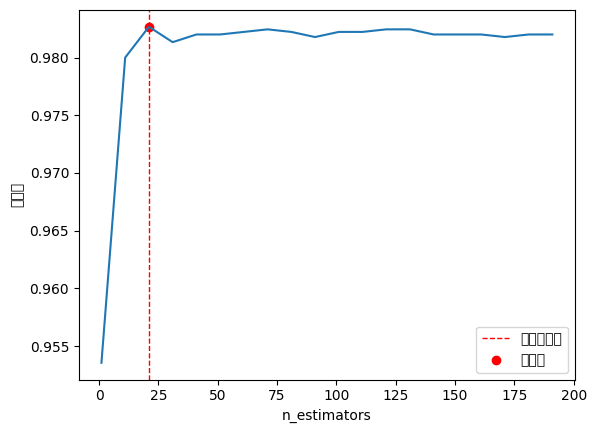

最佳 n_estimators: 21, 准确率: 0.9827


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20339 (\N{CJK UNIFIED IDEOGRAPH-4F73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

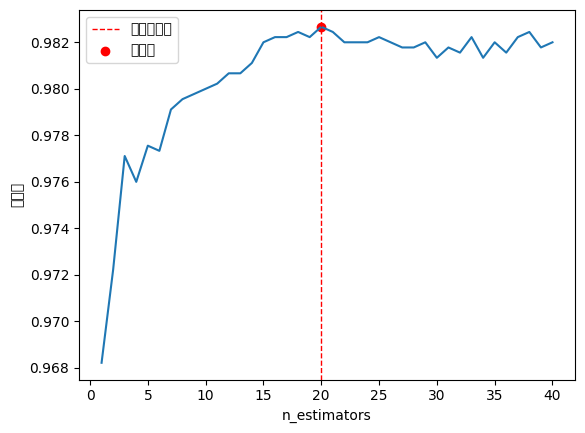

最终最佳 n_estimators: 20, 准确率: 0.9827


In [20]:
#随机森林模型参数优化
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# 自定义归一化类
class Normalizer:
    def __init__(self, dataframe):
        """
        初始化类，接收一个DataFrame作为输入。
        """
        self.dataframe = dataframe
        self.scaler = MinMaxScaler()
        self.scaler_params = None

    def get_normalization_params(self):
        """
        获取归一化参数（基于MinMaxScaler）。
        """
        # 拟合数据以获取归一化参数
        self.scaler.fit(self.dataframe)
        
        # 保存归一化参数
        self.scaler_params = {
            'data_min': self.scaler.data_min_,
            'data_max': self.scaler.data_max_
        }
        return self.scaler_params

    def preprocess(self, otherdata=None):
        """
        对数据进行归一化处理。
        使用类中的归一化参数，如果参数为空则抛出提示。

        参数:
        - otherdata: 可选参数，指定需要归一化的数据。如果未提供，则默认使用类中的dataframe。
        """
        if self.scaler_params is None:
            raise ValueError("归一化参数为空！请先调用 `get_normalization_params` 方法获取归一化参数。")
        
        # 如果未提供otherdata，则使用类中的dataframe
        if otherdata is None:
            otherdata = self.dataframe
        
        # 使用类中的归一化参数进行归一化
        data_min = self.scaler_params['data_min']
        data_max = self.scaler_params['data_max']
        normalized_data = (otherdata - data_min) / (data_max - data_min)
        
        # 将归一化后的数据转换回DataFrame
        normalized_df = pd.DataFrame(normalized_data, columns=otherdata.columns)
        return normalized_df


# 从 CSV 文件中读取数据

df_drop = pd.read_csv(r'/kaggle/input/yuangonglizhi-process-data/processed_data.csv') 

# 假设 df_drop 是数据集，目标列为 'Attrition'
df_X = df_drop.drop('离职', axis=1)  # 特征数据
df_Y = df_drop['离职']              # 目标数据

# 固定训练集和测试集的划分
xtrain, xtest, ytrain, ytest = train_test_split(df_X, df_Y, test_size=0.3, random_state=68)

# 使用 Normalizer 归一化数据
normalizer = Normalizer(xtrain)
normalizer.get_normalization_params()
xtrain = normalizer.preprocess()
xtest = normalizer.preprocess(xtest)

# 初始化随机森林模型
rf = RandomForestClassifier(
    n_estimators=28,           # 树的数量
    max_depth=18,              # 树的最大深度
    min_samples_leaf=2,        # 叶节点所需的最小样本数
    min_samples_split=2,       # 分裂内部节点所需的最小样本数
    max_features=24,           # 寻找最佳分裂时考虑的特征数量
    criterion='gini',          # 分裂标准
    random_state=68,           # 随机种子
    n_jobs=-1                  # 使用所有 CPU 核心
)

# 训练模型
rf.fit(xtrain, ytrain)

# 评估模型
score = rf.score(xtest, ytest)

# 固定交叉验证的随机种子
kf = KFold(n_splits=5, shuffle=True, random_state=68)
cross_s = cross_val_score(rf, xtest, ytest, cv=kf).mean()

# 输出结果
print('随机森林测试集准确率:', score)
print('随机森林交叉验证准确率:', cross_s)

# 调参第一步：调整 n_estimators
cross = []
for i in range(0, 200, 10):
    rf = RandomForestClassifier(n_estimators=i+1, n_jobs=-1, random_state=68)
    cross_score = cross_val_score(rf, xtest, ytest, cv=kf).mean()
    cross.append(cross_score)

plt.plot(range(1, 201, 10), cross)
max_index2 = (cross.index(max(cross)) * 10) + 1
plt.axvline(x=max_index2, color='red', linestyle='--', linewidth=1, label='最佳值位置')
plt.scatter(max_index2, max(cross), color='red', label='最佳值')
plt.xlabel('n_estimators')
plt.ylabel('准确率')
plt.legend()
plt.show()
print(f"最佳 n_estimators: {max_index2}, 准确率: {max(cross):.4f}")

# 缩小范围进一步调整 n_estimators
cross = []
for i in range(max_index2 - 20, max_index2 + 20):
    rf = RandomForestClassifier(n_estimators=i+1, n_jobs=-1, random_state=68)
    cross_score = cross_val_score(rf, xtest, ytest, cv=kf).mean()
    cross.append(cross_score)

plt.plot(range(max_index2 - 20, max_index2 + 20), cross)
best_index = cross.index(max(cross)) + (max_index2 - 20)
plt.axvline(x=best_index, color='red', linestyle='--', linewidth=1, label='最佳值位置')
plt.scatter(best_index, max(cross), color='red', label='最佳值')
plt.xlabel('n_estimators')
plt.ylabel('准确率')
plt.legend()
plt.show()
print(f"最终最佳 n_estimators: {best_index}, 准确率: {max(cross):.4f}")
